# Lognormal test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering the quarter of the sky with $|\cos\theta|<1/2$ and $\pi/2 < \phi < 3\pi/2$. See the [lognormal catalog notebook](lognormal_catalog.ipynb) for more details.

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt
#
sys.path.append('../sht')
from sht import DirectSHT
from  mocks import LogNormalMocks
from  mask_deconvolution import MaskDeconvolution
from  window_function import make_cl

JAX not found. Falling back to NumPy.
JAX not found. Falling back to NumPy.


In [2]:
# Set up an sht instance.  We will set
# Nx to be quite large, so that we are
# confident in our interpolation.
Nl   = 2**8
Nx   = 4*Nl+1
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
sht_randoms = DirectSHT(Nl*2,Nx,xmax)
#
print("Direct SHT has Nl=",Nl,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",2*Nl,", Nx=",Nx," and xmax=",xmax)


Direct SHT has Nl= 256 , Nx= 1025  and xmax= 0.625
For randoms, Direct SHT has Nl= 640 , Nx= 1025  and xmax= 0.625


In [3]:
# Generate some lognormal mocks
npnt_fullsky = 4 * 100000

# Initialize a helper object from which to draw realizations
Mocks_obj = LogNormalMocks(npnt_fullsky, nside=2048, 
                           theta_range=[np.arccos(0.5), np.arccos(-0.5)],
                           phi_range=[np.pi/2, 3*np.pi/2])

# Draw a realization, specifying the random seed if you want
thetas,phis,wts = Mocks_obj(seed=0)
#
npnt = len(thetas)
nbar = npnt / (4*np.pi) # Objects/sr.
#
print("Kept {:d} objects in cut.".format(len(wts)))

gmap in range (-5.505548e+00,5.205058e+00)
emap in range (1.879451e-05,8.425351e-01)
Kept 100018 objects in cut.


In [4]:
# Get a random number generator.
seed = None
rng = np.random.default_rng(seed)

# Generate a random catalog.
nrand = 10*len(thetas)
trand = np.arccos( rng.uniform(low=-0.5,high=0.5,size=nrand) )
prand = rng.uniform(low=np.pi/2,high=3*np.pi/2,size=nrand)
wrand = np.ones_like(trand) * float(npnt)/float(trand.size)

In [5]:
# Calculate the angular power spectrum of the randoms

# TODO: Note that we need W_l at 2*lmax!! So we should initialize another sht object

hran_forwl = sht_randoms(trand,prand,wrand)
hrcl_forwl = hp.alm2cl(hran_forwl)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
sn = 1.0/float(nrand)/(4*np.pi) * float(npnt)**2
wl   = hrcl_forwl - sn
#wl[:2] = 0.0

Sorting took  0.06943011283874512  seconds.
Digitizing & reshaping took  3.4411418437957764  seconds.
Precomputing vs took  11.698606729507446  seconds.
Computing alm's took  1.9038341045379639  seconds.
Sorting took  0.0712587833404541  seconds.
Digitizing & reshaping took  3.708904981613159  seconds.
Precomputing vs took  12.000920057296753  seconds.
Computing alm's took  2.006891965866089  seconds.


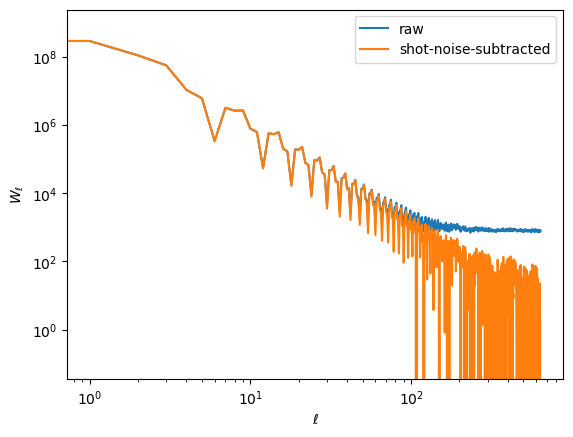

In [6]:
plt.loglog(wl + sn, label='raw')
plt.loglog(wl, label='shot-noise-subtracted')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()

In [7]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
MD = MaskDeconvolution(Nl,wl)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


In [8]:
# If we wanted to put more structure in the mask
# here we could "cut out" various pieces of the
# disk, vetoing both data and random points.

## Harmonic analysis.

Let's compute the $a_{\ell m}$ by direct summation, then compute the binned, pseudo-power spectrum and finally look at the sources on a map.

In a notebook this is kind of slow, but not unmanageable (around a minute).

In [9]:
NperBin = 2**4
bins    = MD.binning_matrix('linear',0,NperBin)

In [10]:
#halm = sht(thetas,phis,wts)
hcl  = hp.alm2cl(halm)
# Bin them up.

# Work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells, hcl_decoupled = MD(hcl,bins)
#binned_ells, hcl_decoupled = binned_ells[Ndiscard:-Ndiscard],hcl_decoupled[Ndiscard:-Ndiscard]

Sorting took  0.004591226577758789  seconds.
Digitizing & reshaping took  0.40030598640441895  seconds.
Precomputing vs took  0.7631397247314453  seconds.
Computing alm's took  0.3697061538696289  seconds.
Sorting took  0.00473332405090332  seconds.
Digitizing & reshaping took  0.36552882194519043  seconds.
Precomputing vs took  0.7344367504119873  seconds.
Computing alm's took  0.37963223457336426  seconds.


In [11]:
hcl_decoupled

Sorting took  0.07019782066345215  seconds.
Digitizing & reshaping took  0.46442627906799316  seconds.
Precomputing vs took  3.8679962158203125  seconds.
Computing alm's took  0.3458528518676758  seconds.
Sorting took  0.07219386100769043  seconds.
Digitizing & reshaping took  0.3926241397857666  seconds.
Precomputing vs took  3.773341178894043  seconds.
Computing alm's took  0.35827088356018066  seconds.


Text(0, 0.5, 'Estimated $C_\\ell$')

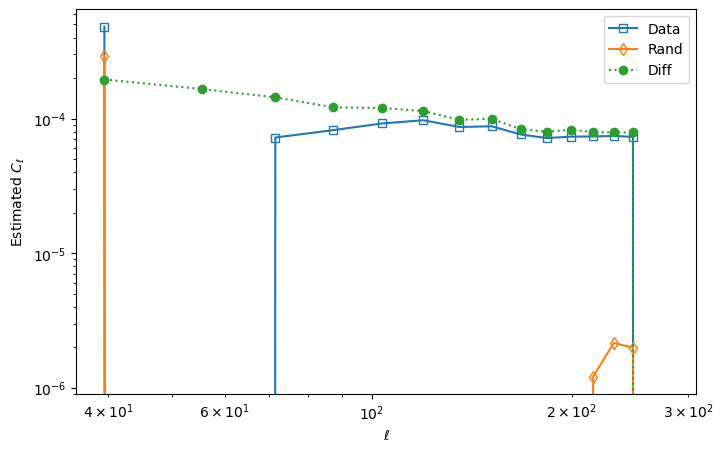

In [12]:
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)

binned_ells, hrcl_decoupled = MD(hrcl,bins)
binned_ells, hrcl_decoupled = binned_ells[Ndiscard:-Ndiscard],hrcl_decoupled[Ndiscard:-Ndiscard]

# and the difference of data and randoms:
hdif = hp.alm2cl(halm - hran)
binned_ells, hdif_decoupled = MD(hdif,bins)
binned_ells, hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

Text(0, 0.5, 'Estimated $C_\\ell$')

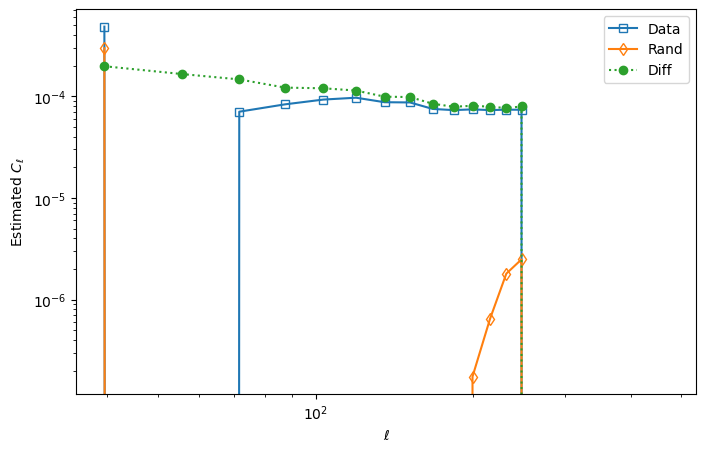

In [31]:
plt.loglog(binned_ells,- hrcl_decoupled,'d-',color='C1',mfc='None',label='Rand')
plt.loglog(binned_ells,- hcl_decoupled,'o:',color='C2',label='Diff')

In [13]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hcl_decoupled,'s-',color='C0',mfc='None',label='Data')
ax.plot(binned_ells,hrcl_decoupled,'d-',color='C1',mfc='None',label='Rand')
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Diff')
#
ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'Estimated $C_\ell$')

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

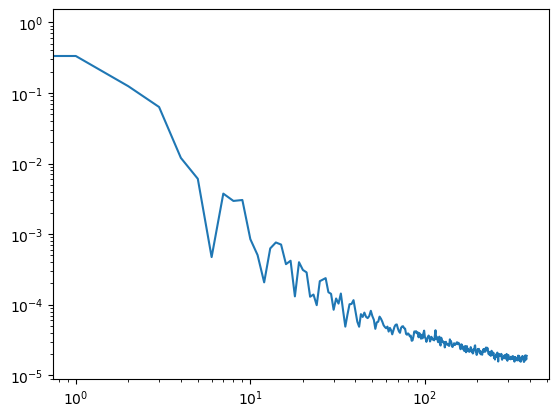

In [15]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

In [16]:
# Show an example at some nside.
# Eventually want to plot in grey the masked region
# and make it look pretty.
nside= 128
dmap = make_map(thetas,phis,wts  ,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
dmap[rmap<=0]=0.0
dmap = dmap/(rmap+1e-30)
ma   = hp.pixelfunc.ma(dmap)
hp.mollview(dmap,min=-1,max=3,norm='hist',title='Density')
hp.graticule()
plt.show()

Text(0, 0.5, 'Healpy $C_\\ell$')

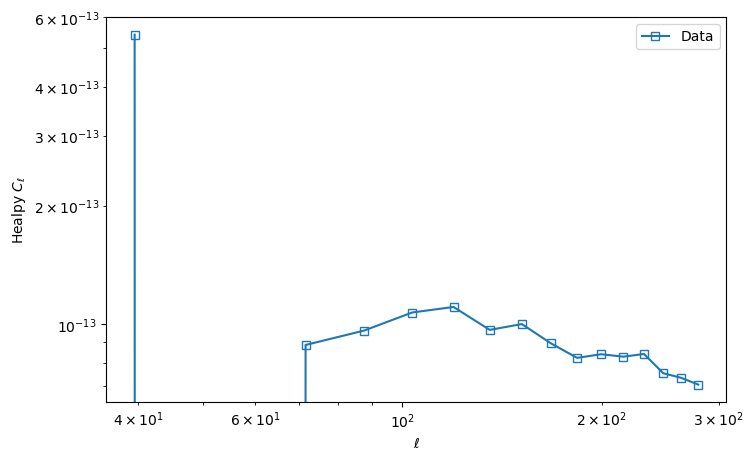

In [17]:
cl_via_map = hp.anafast(dmap)
plt.loglog(cl_via_map)

In [25]:
# Deconvolve the mask
binned_ells, mapcl_decoupled = MD(cl_via_map,bins)
binned_ells, mapcl_decoupled = binned_ells[Ndiscard:-Ndiscard], mapcl_decoupled[Ndiscard:-Ndiscard]

In [17]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,-mapcl_decoupled,'s-',color='C0',mfc='None',label='Data')

ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'Healpy $C_\ell$')

Now compare the power spectra as a function of the map Nside.

In [17]:
fig,ax = plt.subplots(1,2,sharey=False,figsize=(8,4.2))
#
ax[0].loglog(ell,hdif,'s-',mfc='None')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\langle |a_{\ell m}|^2\rangle_m$')
#
icol= 0
for nside in [128,256,512]:
    dmap = make_map(thetas,phis,wts  ,nside)
    rmap = make_map(trand,prand,wrand,nside)
    #dmap[rmap<=0]=0.0
    # Need to divide by randoms etc.
    #mcl  = hp.sphtfunc.anafast(dmap/(rmap+1e-30)-1,alm=False,\
    #                           lmax=sht.Nell-1,pol=False)
    mcl  = hp.sphtfunc.anafast(dmap-rmap,alm=False,\
                               lmax=sht.Nell-1,pol=False)
    # Need to normalize this appropriately.
    # mcl *= nbar**2
    # Now form the ratio with the direct harmonic answer.
    ratio= np.dot(bins,mcl)/hcl
    pixwn= hp.pixwin(nside)
    #
    ax[1].plot(ell,ratio,'s-',color='C'+str(icol),alpha=0.5,\
               mfc='None',label='${:4d}$'.format(nside))
    ax[1].plot(np.arange(pixwn.size),pixwn,ls=':',color='C'+str(icol))
    icol = (icol+1)%10
ax[1].axhline(1.0,ls=':',color='k')
ax[1].set_xlim(8.0,520)
ax[1].set_ylabel(r'Power ratio (map/harmonic)')
ax[1].legend(title=r'$N_{\rm side}$',loc=2)
#ax[1].set_ylim(0.9,1.1)
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$\ell$')
#
plt.tight_layout()
#plt.savefig('lognormal.pdf')

# The End